# 4. Word-Based Modelling Preparation

In this notebook, the lyrics are modified and prepared such that the language model can be trained. In order to do so, some further processing steps are needed as the model architecture works with numbers instead of words. Furthermore, some cleaning of the data will be done before that.<br><br>
__Note:__ Training the model will be done in the next notebook.

In [ ]:
import re
import numpy as np
import string
import collections # to count frequency of tokens
!pip install more_itertools # for splitting list into sublists
from more_itertools import split_before 
import tensorflow as tf
from tensorflow.data import Dataset
import matplotlib.pyplot as plt
import nltk
nltk.download('averaged_perceptron_tagger') # for using default pos_tag
nltk.download('universal_tagset') # for using pos_tag with tagset = "universal"

## Tokenizing

In [1]:
# load lyrics
with open("./data/lyrics.txt", encoding="utf-8") as f:
    lyrics = f.read()

In [2]:
# number of lines
print(len(lyrics))

49387903


In [ ]:
# only take first 1000 lyrics
#re.findall("<START>", lyrics)
# end = [string.start() for string in re.finditer(r"<START>" , lyrics)][1001]
# lyrics = lyrics[0:end]
# print(len(lyrics))

In order to work with the lyrics, the songs should be split up into lists (tokenized). Furthermore, in order to reduce the number of words, all are turned into lowercase.

In [3]:
# function to convert words into tokens and store each song in a separate list
def tokenize(text: str):

  # turn to all lowercase to reduce vocabulary size
  text = text.lower()

  # remove punctuation but keep <> for <START>
  punctuation = "".join([punct for punct in string.punctuation if punct not in {"<", ">", "'"}])
  for punct in punctuation:
      text = text.replace(punct, ' '+punct+' ')

  # split by whitespace and newline, keep newline character
  words = re.split(r"( |\n)", text)

  # remove whitespace from list
  unwanted = {"", " "}
  words = [elem for elem in words if elem not in unwanted]

  # split list into sublists (1 list per song)
  # there should be a strict separation between songs, ie. the last words from one
  #  song should not be used to predict the first words from the next song
  words = list(split_before(words, lambda x: x == "<start>"))

  # remove <start> tag (= first token)
  words = [song[1:] for song in words]

  # remove "\n" as first token from the songs
  songs = []
  for i, song in enumerate(words):
    while song[0] == "\n":
      song = song[1:]
    songs.append(song)
  
  # returns nested list (1 song = 1 list)
  return(songs)

In [ ]:
words = tokenize(lyrics)

In [ ]:
words[0]

['there', "ain't", 'no', 'gold', 'in', 'this', 'river', '\n', 'that', "i've", 'been', "washin'", 'my', 'hands', 'in', 'forever', '\n', 'i', 'know', 'there', 'is', 'hope', 'in', 'these', 'waters', '\n', 'but', 'i', "can't", 'bring', 'myself', 'to', 'swim', '\n', 'when', 'i', 'am', 'drowning', 'in', 'this', 'silence', '\n', 'baby', ',', 'let', 'me', 'in', '\n', '\n', 'go', 'easy', 'on', 'me', ',', 'baby', '\n', 'i', 'was', 'still', 'a', 'child', '\n', "didn't", 'get', 'the', 'chance', 'to', '\n', 'feel', 'the', 'world', 'around', 'me', '\n', 'i', 'had', 'no', 'time', 'to', 'choose', 'what', 'i', 'chose', 'to', 'do', '\n', 'so', 'go', 'easy', 'on', 'me', '\n', '\n', 'there', "ain't", 'no', 'room', 'for', 'things', 'to', 'change', '\n', 'when', 'we', 'are', 'both', 'so', 'deeply', 'stuck', 'in', 'our', 'ways', '\n', 'you', "can't", 'deny', 'how', 'hard', 'i', 'have', 'tried', '\n', 'i', 'changed', 'who', 'i', 'was', 'to', 'put', 'you', 'both', 'first', '\n', 'but', 'now', 'i', 'give', 'up'

In [ ]:
# number of songs
len(words)

15496

Next, we count the occurences of each word to find words that occur only a few times. They will not be very useful for our model, as the model cannot really learn what follows after them when there are is only a little amount of training data.

In [ ]:
# count words
all_words = [x for xs in words for x in xs]
c = collections.Counter(all_words)

In [ ]:
all_words[10000:10100]

['much', 'too', 'late', '\n', 'and', 'you', 'deserve', 'someone', 'better', '\n', '\n', 'save', 'your', 'tears', 'for', 'another', 'day', '(', 'oh', 'yeah', ')', '\n', 'save', 'your', 'tears', 'for', 'another', 'day', '(', 'yeah', ')', '\n', '\n', 'i', "don't", 'know', 'why', 'i', 'run', 'away', '\n', "i'll", 'make', 'you', 'cry', 'when', 'i', 'run', 'away', '\n', 'save', 'your', 'tears', 'for', 'another', 'day', '\n', 'ooh', ',', 'girl', ',', 'i', 'said', '(', 'ah', ')', '\n', 'save', 'your', 'tears', 'for', 'another', 'day', '(', 'ah', ')', '\n', '\n', 'save', 'your', 'tears', 'for', 'another', 'day', '(', 'ah', ')', '\n', 'save', 'your', 'tears', 'for', 'another', 'day', '(', 'ah', ')', '\n', 'i', "wouldn't"]

In [ ]:
# filter out uncommon words, s.t. only words that occur more than x times are kept
MIN_OCCURENCE = 7
dictionary = dict(c)
print("number of words before filter: {}".format(len(dictionary)))
uncommon_words = sorted({k for k, v in dictionary.items() if v < MIN_OCCURENCE})
dictionary = sorted({k for k, v in dictionary.items() if v >= MIN_OCCURENCE})
print("number of words after filter: {}".format(len(dictionary)))

number of words before filter: 98557
number of words after filter: 24990


In [ ]:
uncommon_words[8000:8100]

['biddles', 'biddly', 'biddy’s', 'biden', 'bides', 'bidet', 'bidets', 'biding', 'bidness', 'bidou', 'biedermeyer', 'biennale', 'bienvenida', 'bienvenido', 'bienvenidos', 'bierhiven', 'biff', 'bifocal', 'bifurcated', "big's", 'bigalow', 'bigbagbone', 'bigboy', 'bigdud', 'bigfeet', 'bigga', "biggavel'", "bigger's", "bigges'", 'biggidy', "biggie's", 'biggies', 'biggie’s', 'biggin', "biggin'", 'bigging', 'biggio', 'biggish', 'biggity', 'biggood', "biggs'", 'biggy', 'biggz', 'bighead', 'bighorn', 'bight', 'bigness', 'bigot', 'bigotes', 'bigotry', 'bigots', 'bigrented', 'bigrob', 'bigslaps', 'bigsplash', 'biguidd', 'bigwig', 'bigwigs', 'big—', 'big’in', 'biitch', 'bijan', 'bikers', 'bikeygels', "bikin'", 'bil', "bil'", 'bilal', 'bilaws', 'bilbos', 'bile', 'bilge', 'biliary', 'biling', 'bilingual', 'bilious', 'bilive', 'bilks', "bill'", "bill's", 'billable', 'billers', 'billet', 'billets', 'billfold', 'billi', 'billiard', 'billiards', 'billies', 'billin', "billin'", 'billing', 'billington', '

## Handling uncommon words

Instead of deleting uncommon words, we replace them with their word-type, eg. noun, verb etc. With this, we don't have to omit sequences that contain these words and the model can still learn some basic sentence structure using them. This procedure is needed to **allow our model to work with user input that contains a word that is not in the dictionary** of our model.

In [ ]:
# get POS tag of uncommon words (ie. if it's a noun, verb etc.)
# replace uncommon word with it's tag
pos = nltk.pos_tag(uncommon_words, tagset = "universal")
print(pos[8000:8100])
# consider using tagset = "universal" which only returns NOUN, ADJ etc.
# only keep tags
pos = ["<" + tag + ">" for (word, tag) in pos]

[('biddles', 'NOUN'), ('biddly', 'ADV'), ('biddy’s', 'VERB'), ('biden', 'ADJ'), ('bides', 'NOUN'), ('bidet', 'VERB'), ('bidets', 'NOUN'), ('biding', 'VERB'), ('bidness', 'NOUN'), ('bidou', 'NOUN'), ('biedermeyer', 'NOUN'), ('biennale', 'NOUN'), ('bienvenida', 'NOUN'), ('bienvenido', 'NOUN'), ('bienvenidos', 'VERB'), ('bierhiven', 'ADV'), ('biff', 'ADJ'), ('bifocal', 'ADJ'), ('bifurcated', 'VERB'), ("big's", 'NOUN'), ('bigalow', 'ADP'), ('bigbagbone', 'NOUN'), ('bigboy', 'NOUN'), ('bigdud', 'NOUN'), ('bigfeet', 'NOUN'), ('bigga', 'NOUN'), ("biggavel'", 'NOUN'), ("bigger's", 'NOUN'), ("bigges'", 'NOUN'), ('biggidy', 'NOUN'), ("biggie's", 'NOUN'), ('biggies', 'NOUN'), ('biggie’s', 'VERB'), ('biggin', 'NOUN'), ("biggin'", 'NOUN'), ('bigging', 'VERB'), ('biggio', 'ADJ'), ('biggish', 'ADJ'), ('biggity', 'NOUN'), ('biggood', 'NOUN'), ("biggs'", 'NOUN'), ('biggy', 'NOUN'), ('biggz', 'NOUN'), ('bighead', 'NOUN'), ('bighorn', 'VERB'), ('bight', 'ADJ'), ('bigness', 'NOUN'), ('bigot', 'VERB'), ('b

In [ ]:
nltk.pos_tag(["Lumos"], tagset = "universal")

[('Lumos', 'NOUN')]

In [ ]:
nltk.pos_tag(["wait","until"], tagset = "universal")

[('wait', 'NOUN'), ('until', 'ADP')]

In [ ]:
# there are 12 tag-types
np.unique(pos)

array(['<.>', '<ADJ>', '<ADP>', '<ADV>', '<CONJ>', '<DET>', '<NOUN>',
       '<NUM>', '<PRON>', '<PRT>', '<VERB>', '<X>'], dtype='<U6')

In [ ]:
# create dictionary of uncommon word : tag
pos_dict = dict(zip(uncommon_words, pos))

In [ ]:
# add tags to dictionary
dictionary.extend(np.unique(pos))
# dictionary[len(dictionary) - 13:len(dictionary) - 1]

In [ ]:
# replace uncommon words with their tags
count_replaced = 0
for i, song in enumerate(words):
  for j, word in enumerate(song):
    if word in pos_dict:
      #print((i,j, word))
      #print(words[i][j])
      words[i][j] = pos_dict[word]
      count_replaced += 1
print("replaced words:", count_replaced)    

replaced words: 151972


In [ ]:
# most common words in our trainings lyrics
c.most_common(10)

[('\n', 984638), (',', 613673), ('the', 319020), ('i', 259627), ('you', 245381), ('to', 178527), ('and', 178509), ('a', 165695), ('.', 130654), (')', 124164)]

## Create dictionaries for switching between numeric and real representation

An important step is to create two dictionaries. One that maps a word to it's numerical representation (index) and one that does it the other way around. Using them, we can switch between representations and train the model on numerical data which can then later be changed back to the actual words.

In [ ]:
# define two dictionaries for mapping words to numbers and back
word_to_index = dict((c, i) for i, c in enumerate(dictionary))
index_to_word = dict((i, c) for i, c in enumerate(dictionary))

In [ ]:
list(index_to_word.items())[0:20]

[(0, '\n'), (1, '!'), (2, '"'), (3, '$'), (4, '%'), (5, '&'), (6, "'"), (7, "'03"), (8, "'09"), (9, "'42"), (10, "'64"), (11, "'65"), (12, "'69"), (13, "'70s"), (14, "'80s"), (15, "'87"), (16, "'88"), (17, "'89"), (18, "'90s"), (19, "'92")]

## Splitting into predictor / target

The model works with sequential data (our song lyrics). It takes a sequence of fixed size (eg. 5 words / tokens) to predict the next word. For example:<br><br>
['there', "ain't", 'no', 'gold', 'in'] -> ['this']<br>
["ain't", 'no', 'gold', 'in', 'this'] -> ['river']<br><br>
and so on.


In order to determine which sequence length the model should be trained on (eg. how long should the sequence be that can predict the next word?), the average distance between newline characters is calculated, which corresponds to the average length of lines in the song lyrics.

In [ ]:
# find average distance between newline characters to determine optimal Sequence Length
# = average length of lines in lyrics
positions = [i for i, x in enumerate(all_words) if x == "\n"]

diff = np.diff(positions)
# sort from high to low
diff[::-1].sort()
# some huge outliers on the higher end
diff

array([7214, 5648, 5506, ...,    1,    1,    1])

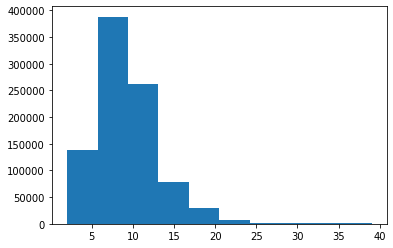

In [ ]:
# treat high values and newline characters that follow each other as outliers
plt.hist(diff[(diff > 1) & (diff < 40)])
plt.show()

In [ ]:
# average lenght of line
np.mean(diff[(diff > 1) & (diff < 40)])
# ~ 10

9.331346001383288

Next, we need to create the training data. As described before, it consists of sequences of a certain length as the X-data, and the following word as the Y-data. In order to not predict the first word of the next song by the last words of the previous song, we have created a nested list of lyrics which allows us to stop at the last word for each song.

In [ ]:
# make sequences for every song seperately
# take sequence lenght corresponding to the average line length in our dataset to provide more context
SEQ_LENGTH = 10

# sequences will be the predictor data and next_word the target
sequences = []
next_word = []

In [ ]:
# number of songs
N_SONGS = len(words)

# number of tokens in each song (words)
song_lengths = [len(x) for x in words]

In [ ]:
song_lengths[0:10]

[249, 541, 791, 565, 501, 863, 650, 533, 807, 741]

In [ ]:
# loop over data to create context for the prediction (next word)
# NOTE: Also included is code that would ignore sequences which contain uncommon words
# BUT: uncommon words were above treated differently (replaced by tag)
# code is kept in case we switch back to this approach
uncommon = set(uncommon_words)
count_ignored = 0

# loop over every song
for song in range(0, N_SONGS):

  # for every song create sequences of x words plus the next one until the length of the song
  for word in range(0, song_lengths[song] - SEQ_LENGTH - 1):

    # take sentence of length SEQ_LENGTH + 1 (also take the next word)
    sentence = words[song][word: word + SEQ_LENGTH + 1]

    # if sentence has one of the uncommon words, skip it
    if len(set(sentence).intersection(uncommon)) == 0: 
      sequences.append(sentence[0:SEQ_LENGTH])
      next_word.append(sentence[SEQ_LENGTH])
      #next_word.append(words[song][word + SEQ_LENGTH])
    else:
      count_ignored += 1

print("Number of sequences:", len(sequences))
print("Ignored sequences:", count_ignored) # should be 0

Number of sequences: 10315059
Ignored sequences: 0


In [ ]:
sequences[1000:1002]

[['hah', '\n', 'but', 'these', 'niggas', 'bitches', 'like', '<NOUN>', ',', 'yeah'], ['\n', 'but', 'these', 'niggas', 'bitches', 'like', '<NOUN>', ',', 'yeah', ',']]

In [ ]:
next_word[1000:1002]

[',', 'yeah']

Now we turn to numerical representation by using our word_to_index dictionary.

In [ ]:
x_vector = []
y_vector = []

# turn to numerical representation
for seq in range(0, len(sequences)):
  single_seq = []
  for word in sequences[seq]:
    single_seq.append(word_to_index[word])
  
  x_vector.append(single_seq)
  y_vector.append(word_to_index[next_word[seq]])

In [ ]:
len(x_vector)

10315059

In [ ]:
len(y_vector)

10315059

In [ ]:
x_vector[10000:10002]

[[11621, 24302, 2045, 7111, 14895, 22208, 14007, 24553, 0, 24212], [24302, 2045, 7111, 14895, 22208, 14007, 24553, 0, 24212, 477]]

In [ ]:
y_vector[10000:10002]

[477, 23992]

As the data is quite large (more than 10 million sequences and several tens of thousands of unique words), we create a Data Generator that allows us to create batches of data. See here: https://github.com/klaudia-nazarko/nlg-text-generation/blob/main/LSTM_class.py

In [ ]:
from tensorflow.keras.utils import Sequence

In [ ]:
# create class for fitting to a sequence of data
# useful for multiprocessing
class TextDataGenerator(Sequence):
    def __init__(self, sequences, next_words, sequence_length, vocab_size, batch_size=32, shuffle=True, embedding=False):
        self.batch_size = batch_size
        self.sequences = sequences
        self.next_words = next_words
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.shuffle = shuffle
        self.embedding = embedding
        self.on_epoch_end()

    # must be implemented for class Sequence
    def __len__(self):
        return int(np.floor(len(self.sequences) / self.batch_size))

    # must be implemented for class Sequence, gets batch at position index
    def __getitem__(self, index):
        # take sample of indexes, length = batch_size
        indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]

        # store relevant x and y data
        sequences_batch = [self.sequences[k] for k in indexes]
        next_words_batch = [self.next_words[k] for k in indexes]

        if self.embedding:
          X = np.array(sequences_batch)
          y = keras.utils.to_categorical(next_words_batch, num_classes=self.vocab_size)
        else:
          X, y = self.__data_generation(sequences_batch, next_words_batch)

        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.sequences)) # vector of length len(x_data)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, sequences_batch, next_words_batch):
        # create empty, 3 dimensional matrices
        X = np.zeros((self.batch_size, self.sequence_length, self.vocab_size), dtype=bool)
        y = np.zeros((self.batch_size, self.vocab_size), dtype=bool)

        # fill matrices with 1 at the position of the word, essentially one-hot encoding
        for i, seq in enumerate(sequences_batch):
            for j, word in enumerate(seq):
                X[i, j, word] = 1
                y[i, next_words_batch[i]] = 1
        return X, y

In [ ]:
BATCH_SIZE = 64
VOCAB_SIZE = len(dictionary)

params = {
  'sequence_length': SEQ_LENGTH,
  'vocab_size': VOCAB_SIZE,
  'batch_size': BATCH_SIZE,
  'shuffle': True
}

train_generator = TextDataGenerator(x_vector, y_vector, **params)

In [ ]:
print("Size of Vocabulary: {}".format(VOCAB_SIZE))
print("Number of Sequences: {}".format(len(sequences)))

Size of Vocabulary: 25002
Number of Sequences: 10315059


## Export Objects to use in the next notebooks

In [ ]:
# Saving relevant objects for applying the model
import pickle
with open('./data/objs.pkl', 'wb') as f:
    pickle.dump([c, dictionary, index_to_word, word_to_index, SEQ_LENGTH, VOCAB_SIZE, BATCH_SIZE], f)

In [ ]:
# saving relevant objects for training the model
with open('./data/objs_rel.pkl', 'wb') as f:
    pickle.dump([SEQ_LENGTH, VOCAB_SIZE, train_generator], f)